# Dịch máy thần kinh

Chào mừng bạn đến với bài tập lập trình đầu tiên của bạn cho tuần này!

* Bạn sẽ xây dựng mô hình Neural Machine Translation (NMT) để dịch những ngày tháng mà con người có thể đọc được ("ngày 25 tháng 6 năm 2009") thành những ngày tháng mà máy móc có thể đọc được ("2009-06-25").
* Bạn sẽ làm điều này bằng cách sử dụng mô hình chú ý, một trong những mô hình tuần tự phức tạp nhất.

Sổ tay này được sản xuất cùng với Viện Học tập Sâu của NVIDIA.

## Table of Contents

- [Packages](#0)
- [1 - Translating Human Readable Dates Into Machine Readable Dates](#1)
    - [1.1 - Dataset](#1-1)
- [2 - Neural Machine Translation with Attention](#2)
    - [2.1 - Attention Mechanism](#2-1)
        - [Exercise 1 - one_step_attention](#ex-1)
        - [Exercise 2 - modelf](#ex-2)
        - [Exercise 3 - Compile the Model](#ex-3)
- [3 - Visualizing Attention (Optional / Ungraded)](#3)
    - [3.1 - Getting the Attention Weights From the Network](#3-1)

<a name='0'></a>
## Packages

In [ ]:
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
import tensorflow.keras.backend as K
import tensorflow as tf
import numpy as np

from faker import Faker
import random
from tqdm import tqdm
from babel.dates import format_date
from nmt_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

<a name='1'> </a>
## 1 - Chuyển các ngày có thể đọc của con người sang các ngày có thể đọc được của máy

* Mô hình bạn sẽ xây dựng ở đây có thể được sử dụng để dịch từ ngôn ngữ này sang ngôn ngữ khác, chẳng hạn như dịch từ tiếng Anh sang tiếng Hindi.
* Tuy nhiên, việc dịch ngôn ngữ yêu cầu bộ dữ liệu lớn và thường mất nhiều ngày đào tạo về GPU.
* Để cung cấp cho bạn một nơi để thử nghiệm với các mô hình này mà không cần sử dụng bộ dữ liệu khổng lồ, chúng tôi sẽ thực hiện tác vụ "dịch ngày" đơn giản hơn.
* Mạng sẽ nhập ngày tháng được viết bằng nhiều định dạng có thể có (*ví dụ: "ngày 29 tháng 8 năm 1958", "30/03/1968", "24 tháng 6 năm 1987"*)
* Mạng sẽ dịch chúng thành các ngày chuẩn hóa, máy có thể đọc được (*ví dụ: "1958-08-29", "1968-03-30", "1987-06-24"*).
* Chúng tôi sẽ yêu cầu mạng tìm hiểu để xuất ngày tháng ở định dạng phổ biến mà máy có thể đọc được là YYYY-MM-DD.

<!--
Hãy xem[nmt_utils.py] (./nmt_utils.py) để xem tất cả các định dạng. Đếm và tìm ra cách hoạt động của các định dạng, bạn sẽ cần kiến thức này sau đó. !-->

<a name='1-1'> </a>
### 1.1 - Tập dữ liệu

Chúng tôi sẽ đào tạo mô hình trên tập dữ liệu gồm 10.000 ngày tháng con người có thể đọc được và các ngày tháng tương đương, được tiêu chuẩn hóa, máy móc có thể đọc được. Hãy chạy các ô sau để tải tập dữ liệu và in một số ví dụ.

In [ ]:
m = 10000
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [00:00<00:00, 18566.53it/s]


In [ ]:
dataset[:10]

[('9 may 1998', '1998-05-09'),
 ('10.11.19', '2019-11-10'),
 ('9/10/70', '1970-09-10'),
 ('saturday april 28 1990', '1990-04-28'),
 ('thursday january 26 1995', '1995-01-26'),
 ('monday march 7 1983', '1983-03-07'),
 ('sunday may 22 1988', '1988-05-22'),
 ('08 jul 2008', '2008-07-08'),
 ('8 sep 1999', '1999-09-08'),
 ('thursday january 1 1981', '1981-01-01')]

Bạn đã tải:
- `dataset`: danh sách các bộ giá trị (ngày con người đọc được, ngày máy đọc được).
- `human_vocab`: một từ điển python ánh xạ tất cả các ký tự được sử dụng trong ngày tháng mà con người có thể đọc được thành một chỉ mục có giá trị số nguyên.
- `machine_vocab`: một từ điển python ánh xạ tất cả các ký tự được sử dụng trong ngày tháng có thể đọc được của máy thành một chỉ mục có giá trị nguyên.
     - **Lưu ý**: Các chỉ số này không nhất thiết phải nhất quán với `human_vocab`.
- `inv_machine_vocab`: từ điển nghịch đảo của` machine_vocab`, ánh xạ từ các chỉ số trở lại các ký tự.

Hãy xử lý trước dữ liệu và ánh xạ dữ liệu văn bản thô thành các giá trị chỉ mục.
- Chúng ta sẽ đặt Tx = 30
     - Chúng tôi giả định Tx là độ dài tối đa của ngày có thể đọc được của con người.
     - Nếu chúng tôi nhận được một đầu vào dài hơn, chúng tôi sẽ phải cắt bớt nó.
- Chúng ta sẽ đặt Ty = 10
     - "YYYY-MM-DD" dài 10 ký tự.

In [ ]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)

X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


Bây giờ bạn có:
- `X`: phiên bản đã xử lý của ngày con người có thể đọc được trong tập huấn luyện.
    - Mỗi ký tự trong X được thay thế bằng một chỉ số (số nguyên) được ánh xạ tới ký tự bằng cách sử dụng `human_vocab`.
    - Mỗi ngày được đệm để đảm bảo độ dài $T_x$ bằng cách sử dụng một ký tự đặc biệt (<pad>).
    - `X.shape = (m, Tx)` trong đó m là số lượng ví dụ đào tạo trong một đợt.
- `Y`: phiên bản đã xử lý của máy có thể đọc được ngày tháng trong tập huấn luyện.
    - Mỗi ký tự được thay thế bằng chỉ số (số nguyên) mà nó được ánh xạ tới trong `machine_vocab`.
    - `Y.shape = (m, Ty)`.
- `Xoh`: phiên bản nóng nhất của` X`
    - Mỗi chỉ mục trong `X` được chuyển đổi thành biểu diễn một nóng (nếu chỉ mục là 2, phiên bản một nóng có vị trí chỉ mục 2 được đặt thành 1, và các vị trí còn lại là 0.
    - `Xoh.shape = (m, Tx, len (human_vocab)) '
- `Yoh`: phiên bản hot nhất của` Y`
    - Mỗi chỉ mục trong `Y` được chuyển đổi thành biểu diễn một nóng.
    - `Yoh.shape = (m, Ty, len (machine_vocab)) '.
    - `len (machine_vocab) = 11` vì có 10 chữ số (0 đến 9) và ký hiệu` -`.

* Chúng ta hãy cũng xem xét một số ví dụ về các ví dụ đào tạo tiền xử lý.
* Vui lòng chơi với `index` trong ô bên dưới để điều hướng tập dữ liệu và xem ngày nguồn / đích được xử lý trước như thế nào.

In [ ]:
index = 0
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):", X[index])
print("Target after preprocessing (indices):", Y[index])
print()
print("Source after preprocessing (one-hot):", Xoh[index])
print("Target after preprocessing (one-hot):", Yoh[index])

Source date: 9 may 1998
Target date: 1998-05-09

Source after preprocessing (indices): [12  0 24 13 34  0  4 12 12 11 36 36 36 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices): [ 2 10 10  9  0  1  6  0  1 10]

Source after preprocessing (one-hot): [[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot): [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


<a name='2'> </a>
## 2 - Dịch máy thần kinh có chú ý

* Nếu bạn phải dịch một đoạn sách từ tiếng Pháp sang tiếng Anh, bạn sẽ không đọc hết đoạn văn, sau đó đóng sách và dịch.
* Ngay cả trong quá trình dịch, bạn sẽ đọc / đọc lại và tập trung vào các phần của đoạn tiếng Pháp tương ứng với phần tiếng Anh mà bạn đang viết ra.
* Cơ chế chú ý cho mô hình Dịch máy thần kinh biết nơi nó cần chú ý đến ở bất kỳ bước nào.

<a name='2-1'> </a>
### 2.1 - Cơ chế chú ý

Trong phần này, bạn sẽ thực hiện cơ chế chú ý được trình bày trong các video bài giảng.
* Đây là một con số để nhắc nhở bạn cách hoạt động của mô hình.

    * Sơ đồ bên trái cho thấy mô hình chú ý.

    * Biểu đồ bên phải cho thấy một bước "attention" thực hiện để tính toán các biến attention 𝛼⟨𝑡,𝑡′⟩.
    * Các biến chú ý 𝛼⟨𝑡,𝑡′⟩ $ được sử dụng để tính toán biến ngữ cảnh 𝑐𝑜𝑛𝑡𝑒𝑥𝑡⟨𝑡⟩ cho mỗi bước thời gian trong đầu ra ( 𝑡=1,…,𝑇𝑦 ).

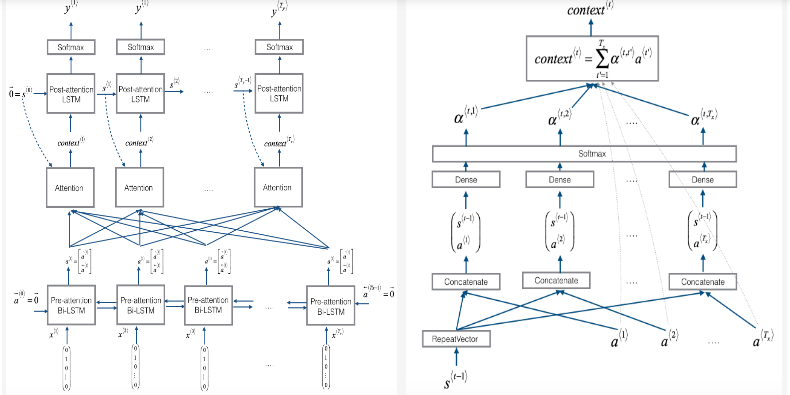

Dưới đây là một số thuộc tính của mô hình mà bạn có thể nhận thấy:

#### LSTM chú ý trước và chú ý sau ở cả hai bên của cơ chế chú ý
- Có hai LSTM riêng biệt trong mô hình này (xem sơ đồ bên trái): LSTM chú ý trước và chú ý sau.
- * Chú ý trước * Bi-LSTM là cái ở dưới cùng của hình là LSTM hai hướng và đến *trước* cơ chế chú ý.
     - Cơ chế chú ý được thể hiện ở giữa sơ đồ bên tay trái.
     - Bi-LSTM được chú ý trước trải qua các bước $ T_x $ time
- * Hậu chú ý * LSTM: ở trên cùng của sơ đồ đến * sau * cơ chế chú ý.
     - LSTM hậu chú ý trải qua các bước $ T_y $ time.

- LSTM sau chú ý chuyển trạng thái ẩn $ s ^ {\ langle t \ rangle} $ và trạng thái ô $ c ^ {\ langle t \ rangle} $ từ bước này sang bước tiếp theo.

#### Một LSTM có cả trạng thái ẩn và trạng thái ô
* Trong các video bài giảng, chúng tôi chỉ sử dụng RNN cơ bản cho mô hình trình tự chú ý sau
     * Điều này có nghĩa là trạng thái được RNN nắm bắt chỉ xuất ra trạng thái ẩn𝑠⟨𝑡⟩ .
* Trong bài tập này, chúng tôi đang sử dụng LSTM thay vì RNN cơ bản.
     * Vì vậy, LSTM có cả trạng thái ẩn 𝑠⟨𝑡⟩ . và trạng thái ô 𝑐⟨𝑡⟩.

#### Mỗi bước thời gian không sử dụng dự đoán từ bước thời gian trước đó
* Không giống như các ví dụ tạo văn bản trước đó trong khóa học, trong mô hình này, LSTM sau sự chú ý tại thời điểm $ t $ không lấy dự đoán của bước thời gian trước 𝑦⟨𝑡−1⟩ làm đầu vào.
* LSTM sau chú ý tại thời điểm 't' chỉ lấy trạng thái ẩn 𝑠⟨𝑡⟩ và trạng thái ô 𝑐⟨𝑡 làm đầu vào.
* Chúng tôi đã thiết kế mô hình theo cách này vì không giống như cách tạo ngôn ngữ (trong đó các ký tự liền kề có tương quan cao), không có sự phụ thuộc mạnh mẽ giữa ký tự trước và ký tự tiếp theo trong một ngày YYYY-MM-DD.

#### Kết hợp các trạng thái ẩn từ LSTM được chú ý trước và lùi về phía sau
- $\overrightarrow{a}^{\langle t \rangle}$: trạng thái ẩn của LSTM hướng về phía trước, chú ý trước.
-$\overleftarrow{a}^{\langle t \rangle}$: trạng thái ẩn của LSTM hướng lùi, chú ý trước.
- $a^{\langle t \rangle} = [\overrightarrow{a}^{\langle t \rangle}, \overleftarrow{a}^{\langle t \rangle}]$: ghép các kích hoạt của cả hai hướng tới $\overrightarrow{a}^{\langle t \rangle}$ và hướng lùi $\overleftarrow{a}^{\langle t \rangle}$ của Bi-LSTM được chú ý trước.

#### Tính toán "năng lượng" $e^{\langle t, t' \rangle}$  dưới dạng một hàm của $ s ^ {\langle t-1 \rangle} $ và $ a ^ {\langle t' \rangle } $
- Nhớ lại trong video bài học "Mô hình chú ý", tại thời điểm 6:45 đến 8:16, định nghĩa của "e" là một hàm của $ s ^ {\langle t-1 \rangle} $ và $ a ^ {\langle t \rangle} $.
     - "e" được gọi là biến "năng lượng".
     - $ s ^ {\langle t-1 \rangle} $ là trạng thái ẩn của LSTM sau chú ý
     - $ a ^ {\langle t '\rangle} $ là trạng thái ẩn của LSTM được chú ý trước.
     - $ s ^ {\langle t-1 \rangle} $ và $ a ^ {\langle t \rangle} $ được đưa vào một mạng nơ-ron đơn giản, mạng này học hàm để xuất ra $ e ^ {\langle t, t ' \rangle} $.
     - $ e ^ {\langle t, t '\rangle} $ sau đó được sử dụng khi tính toán sự chú ý $ a ^ {\langle t, t' \rangle} $ mà $ y ^ {\langle t \rangle} $ phải trả thành $ a ^ {\langle t '\rangle} $

- Sơ đồ bên phải hình 1 sử dụng nút `RepeatVector` để sao chép giá trị $ s ^ {\langle t-1 \rangle} $ của $ T_x $ lần.
- Sau đó, nó sử dụng `Concatenation` để nối $ s ^ {\langle t-1 \rangle} $ và $ a ^ {\langle t \rangle} $.
- Việc nối $ s ^ {\angle t-1 \rangle} $ và $ a ^ {\langle t \rangle} $ được đưa vào một lớp "Dense", lớp này sẽ tính $ e ^ {\langle t, t ' \rangle} $.
- $ e ^ {\langle t, t '\rangle} $ sau đó được chuyển qua softmax để tính $ \alpha ^ {\langle t, t' \rangle} $.
- Lưu ý rằng biểu đồ không hiển thị rõ ràng biến $ e ^ {\langle t, t '\rangle} $, nhưng $ e ^ {\langle t, t' \rangle} $ ở trên lớp Dense và bên dưới Softmax lớp trong sơ đồ ở nửa bên phải của hình 1.
- Chúng tôi sẽ giải thích cách sử dụng `RepeatVector` và` Concatenation` trong Keras bên dưới.

#### Chi tiết Triển khai
   
Hãy thực hiện trình dịch thần kinh này. Bạn sẽ bắt đầu bằng cách triển khai hai hàm: `one_step_attention ()` và `model ()`.

#### one_step_attention
* Các đầu vào cho bước one_step_attention tại thời điểm $ t $ là:
     - [𝑎<1>,𝑎<2>,...,𝑎<𝑇𝑥>] : tất cả các trạng thái ẩn của Bi-LSTM được chú ý trước.
     - 𝑠<𝑡−1>: trạng thái ẩn trước đó của LSTM sau chú ý
* one_step_attention tính:
     - $ [\alpha ^ {<t, 1>}, \alpha ^ {<t, 2>}, ..., \alpha ^ {<t, T_x>}] $: trọng số chú ý
     - $ context ^ {\langle t \rangle} $: vectơ ngữ cảnh:
    
$$ context ^ {<t>} = \sum_ {t '= 1} ^ {T_x} \alpha ^ {<t, t'>} a ^ {<t '>} \tag {1} $$

##### Làm rõ 'ngữ cảnh' và 'c'
- Trong các video bài giảng, ngữ cảnh được ký hiệu là $ c ^ {\langle t \rangle} $
- Trong bài tập, chúng tôi đang gọi ngữ cảnh $ context ^ {\langle t \rangle} $.
     - Điều này để tránh nhầm lẫn với biến ô bộ nhớ trong của LSTM sau chú ý, cũng được ký hiệu là $ c ^ {\langle t \rangle} $.

<a name='ex-1'> </a>
### Bài tập 1 - one_step_attention

Triển khai `one_step_attention ()`.

* Hàm `model ()` sẽ gọi các lớp trong `one_step_attention ()` $ T_y $ lần bằng vòng lặp for.
* Điều quan trọng là tất cả các bản sao $ T_y $ có cùng trọng lượng.
    * Nó không nên bắt đầu lại trọng lượng mỗi lần.
    * Nói cách khác, tất cả các bước $ T_y $ phải có trọng số chung.
* Đây là cách bạn có thể triển khai các lớp với trọng số có thể chia sẻ trong Keras:
    1. Xác định các đối tượng lớp trong một phạm vi biến nằm ngoài hàm `one_step_attention`. Ví dụ, xác định các đối tượng là biến toàn cục sẽ hoạt động.
        - Lưu ý rằng việc xác định các biến này bên trong phạm vi của hàm `model` về mặt kỹ thuật sẽ hoạt động, vì khi đó` model` sẽ gọi hàm `one_step_attention`. Với mục đích giúp việc phân loại và khắc phục sự cố dễ dàng hơn, chúng tôi đang định nghĩa chúng là các biến toàn cục. Lưu ý rằng trình chấm điểm tự động cũng sẽ mong đợi đây là các biến toàn cục.
    2. Gọi các đối tượng này khi truyền đầu vào.
* Chúng tôi đã xác định các lớp bạn cần làm biến toàn cục.
    * Vui lòng chạy các ô sau để tạo chúng.
    * Xin lưu ý rằng trình chấm điểm tự động mong đợi các biến toàn cục này với các tên biến đã cho. Đối với mục đích chấm điểm, vui lòng không đổi tên các biến toàn cục.
* Vui lòng kiểm tra tài liệu Keras để tìm hiểu thêm về các lớp này. Các lớp là các chức năng. Dưới đây là các ví dụ về cách gọi các hàm này.
    * [RepeatVector()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RepeatVector)
```Python
var_repeated = repeat_layer(var1)
```
    * [Concatenate()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate)   
```Python
concatenated_vars = concatenate_layer([var1,var2,var3])
```
    * [Dense()](https://keras.io/layers/core/#dense)  
```Python
var_out = dense_layer(var_in)
```
    * [Activation()](https://keras.io/layers/core/#activation)  
```Python
activation = activation_layer(var_in)  
```
    * [Dot()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dot)  
```Python
dot_product = dot_layer([var1,var2])
```

In [ ]:
# Defined shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights') # We are using a custom softmax(axis = 1) loaded in this notebook
dotor = Dot(axes = 1)

In [ ]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: one_step_attention

def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.
    
    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)
    
    Returns:
    context -- context vector, input of the next (post-attention) LSTM cell
    """
    
    ### START CODE HERE ###
    # Use repeator to repeat s_prev to be of shape (m, Tx, n_s) so that you can concatenate it with all hidden states "a" (≈ 1 line)
    s_prev = repeator(s_prev)
    # Use concatenator to concatenate a and s_prev on the last axis (≈ 1 line)
    # For grading purposes, please list 'a' first and 's_prev' second, in this order.
    concat = concatenator([a,s_prev])
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e. (≈1 lines)
    e = densor1(concat)
    
    # Use densor2 to propagate e through a small fully-connected neural network to compute the "energies" variable energies. (≈1 lines)
    energies =  densor2(e)
    # Use "activator" on "energies" to compute the attention weights "alphas" (≈ 1 line)
    alphas = activator(energies)
    # Use dotor together with "alphas" and "a", in this order, to compute the context vector to be given to the next (post-attention) LSTM-cell (≈ 1 line)
    context = dotor([alphas,a])

    ### END CODE HERE ###
    
    return context

In [ ]:
# UNIT TEST
def one_step_attention_test(target):

    m = 10
    Tx = 30
    n_a = 32
    n_s = 64
    #np.random.seed(10)
    a = np.random.uniform(1, 0, (m, Tx, 2 * n_a)).astype(np.float32)
    s_prev =np.random.uniform(1, 0, (m, n_s)).astype(np.float32) * 1
    context = target(a, s_prev)
    
    #assert type(context) == tf.python.framework.ops.EagerTensor, "Unexpected type. It should be a Tensor"
    assert tuple(context.shape) == (m, 1, n_s), "Unexpected output shape"
    assert np.all(context.numpy() > 0), "All output values must be > 0 in this example"
    assert np.all(context.numpy() < 1), "All output values must be < 1 in this example"

    #assert np.allclose(context[0][0][0:5].numpy(), [0.50877404, 0.57160693, 0.45448175, 0.50074816, 0.53651875]), "Unexpected values in the result"
    print("\033[92mAll tests passed!")
    
one_step_attention_test(one_step_attention)

All tests passed!


<a name='ex-2'> </a>
### Bài tập 2 - modelf

Triển khai `modelf () 'như được giải thích trong hình 1 và các hướng dẫn:

* `modelf` đầu tiên chạy đầu vào thông qua Bi-LSTM để nhận $ [a ^ {<1>}, a ^ {<2>}, ..., a ^ {<T_x>}] $.
* Sau đó, `modelf` gọi` one_step_attention () `$ T_y $ lần bằng cách sử dụng vòng lặp` for`. Tại mỗi lần lặp lại của vòng lặp này:
     - Nó cung cấp vectơ ngữ cảnh được tính toán 𝑐𝑜𝑛𝑡𝑒𝑥𝑡<𝑡> cho LSTM hậu chú ý.
     - Nó chạy đầu ra của LSTM sau chú ý thông qua một lớp dày đặc với kích hoạt softmax.
     - Softmax tạo ra một dự đoán 𝑦̂ <𝑡>.
    
Một lần nữa, chúng tôi đã xác định các lớp toàn cục sẽ chia sẻ trọng số được sử dụng trong `modelf ()`.

In [ ]:
n_a = 32 # number of units for the pre-attention, bi-directional LSTM's hidden state 'a'
n_s = 64 # number of units for the post-attention LSTM's hidden state "s"

# Please note, this is the post attention LSTM cell.  
post_activation_LSTM_cell = LSTM(n_s, return_state = True) # Please do not modify this global variable.
output_layer = Dense(len(machine_vocab), activation=softmax)

Bây giờ bạn có thể sử dụng các lớp $ T_y $ times này trong vòng lặp `for` để tạo kết quả đầu ra và các tham số của chúng sẽ không được khởi động lại. Bạn sẽ phải thực hiện các bước sau:

1. Truyền đầu vào `X` thành LSTM hai chiều.
    * [Bidirectional](https://keras.io/layers/wrappers/#bidirectional)
    * [LSTM](https://keras.io/layers/recurrent/#lstm)
    * Hãy nhớ rằng chúng ta muốn LSTM trả về một chuỗi đầy đủ thay vì chỉ trạng thái ẩn cuối cùng.
    
Mã mẫu:

```Python
sequence_of_hidden_states = Bidirectional(LSTM(units=..., return_sequences=...))(the_input_X)
```
    
2. Lặp lại cho $ t = 0, \ cdots, T_y-1 $:
    1. Gọi `one_step_attention ()`, truyền vào chuỗi các trạng thái ẩn $ [a ^ {\langle 1 \rangle}, a ^ {\langle 2 \rangle}, ..., a ^ {\langle T_x \rangle }] $ từ LSTM hai chiều được chú ý trước và trạng thái ẩn trước đó   𝑠<𝑡−1> từ LSTM sau chú ý để tính toán vectơ ngữ cảnh 𝑐𝑜𝑛𝑡𝑒𝑥𝑡<𝑡> .
    2. Đưa 𝑐𝑜𝑛𝑡𝑒𝑥𝑡<𝑡> vào ô LSTM sau chú ý.
        - Hãy nhớ chuyển ở trạng thái ẩn $ s ^ {\langle t-1 \rangle} $ trước đó và các trạng thái ô $ c ^ {\langle t-1 \rangle} $ của LSTM này
        * Điều này xuất ra trạng thái ẩn mới 𝑠<𝑡> và trạng thái ô mới 𝑐<𝑡> .

        Mã mẫu:
        ```Python
        next_hidden_state, _ , next_cell_state = 
            post_activation_LSTM_cell(inputs=..., initial_state=[prev_hidden_state, prev_cell_state])
        ```  
        Xin lưu ý rằng lớp thực sự là "ô LSTM đăng sự chú ý". Với mục đích vượt qua máy chấm điểm tự động, vui lòng không sửa đổi cách đặt tên của biến toàn cục này. Điều này sẽ được khắc phục khi chúng tôi triển khai các bản cập nhật cho máy chấm điểm tự động.
    3. Áp dụng một lớp softmax dày đặc cho $ s ^ {<t>} $, lấy đầu ra.
        Mã mẫu:
        ```Python
        output = output_layer(inputs=...)
        ```
    4. Lưu kết quả đầu ra bằng cách thêm nó vào danh sách kết quả đầu ra.

3. Tạo cá thể mô hình Keras của bạn.
    * Nó phải có ba đầu vào:
        * `X`, đầu vào được mã hóa một lần cho mô hình, có hình dạng ($T_{x}, humanVocabSize)$
        * $s^{\langle 0 \rangle}$, trạng thái ẩn ban đầu của LSTM sau chú ý
        * $ c ^ {\langle 0 \rangle} $, trạng thái ô ban đầu của LSTM hậu chú ý
    * Đầu ra là danh sách các đầu ra.
    Mã mẫu
    ```Python
    model = Model(inputs=[...,...,...], outputs=...)
    ```

In [ ]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: model

def modelf(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """
    
    # Define the inputs of your model with a shape (Tx,)
    # Define s0 (initial hidden state) and c0 (initial cell state)
    # for the decoder LSTM with shape (n_s,)
    X = Input(shape=(Tx, human_vocab_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = []
    
    ### START CODE HERE ###
    
    # Step 1: Define your pre-attention Bi-LSTM. (≈ 1 line)
    a =  Bidirectional(LSTM(units=n_a, return_sequences=True))(X)
    
    # Step 2: Iterate for Ty steps
    for t in range(Ty):
    
        # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t (≈ 1 line)
        context = one_step_attention (a,s)
        
        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector.
        # Don't forget to pass: initial_state = [hidden state, cell state] (≈ 1 line)
        s, _, c = post_activation_LSTM_cell(inputs=context, initial_state=[s,c])
        
        # Step 2.C: Apply Dense layer to the hidden state output of the post-attention LSTM (≈ 1 line)
        out = output_layer(inputs=c)
        
        # Step 2.D: Append "out" to the "outputs" list (≈ 1 line)
        outputs.append(out)
    
    # Step 3: Create model instance taking three inputs and returning the list of outputs. (≈ 1 line)
    model = Model(inputs=[X,s0,c0], outputs=outputs)
    
    ### END CODE HERE ###
    
    return model

In [ ]:
# UNIT TEST


def modelf_test(target):
    m = 10
    Tx = 30
    n_a = 32
    n_s = 64
    len_human_vocab = 37
    len_machine_vocab = 11
    
    
    model = target(Tx, Ty, n_a, n_s, len_human_vocab, len_machine_vocab)
    

    
    expected_summary = [['InputLayer', [(None, 30, 37)], 0],
                         ['InputLayer', [(None, 64)], 0],
                         ['Bidirectional', (None, 30, 64), 17920],
                         ['RepeatVector', (None, 30, 64), 0, 30],
                         ['Concatenate', (None, 30, 128), 0],
                         ['Dense', (None, 30, 10), 1290, 'tanh'],
                         ['Dense', (None, 30, 1), 11, 'relu'],
                         ['Activation', (None, 30, 1), 0],
                         ['Dot', (None, 1, 64), 0],
                         ['InputLayer', [(None, 64)], 0],
                         ['LSTM',[(None, 64), (None, 64), (None, 64)], 33024,[(None, 1, 64), (None, 64), (None, 64)],'tanh'],
                         ['Dense', (None, 11), 715, 'softmax']]
    

modelf_test(modelf)

In [ ]:
model = modelf(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 30, 37)]     0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 64)]         0                                            
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 30, 64)       17920       input_4[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm[30][0]                

<a name='ex-3'> </a>
### Bài tập 3 - Biên dịch Mô hình

* Sau khi tạo mô hình của bạn trong Keras, bạn cần phải biên dịch nó và xác định hàm mất mát, trình tối ưu hóa và số liệu bạn muốn sử dụng.
     * Loss function: 'categorical_crossentropy'.
    * Optimizer: [Adam](https://keras.io/optimizers/#adam) [optimizer](https://keras.io/optimizers/#usage-of-optimizers)
        - learning rate = 0.005 
        - $\beta_1 = 0.9$
        - $\beta_2 = 0.999$
        - decay = 0.01  
    * metric: 'accuracy'
    
Mã mẫu
```Python
optimizer = Adam(lr=..., beta_1=..., beta_2=..., decay=...)
model.compile(optimizer=..., loss=..., metrics=[...])
```

In [ ]:
### START CODE HERE ### (≈2 lines)
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01) # Adam(...) 
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
### END CODE HERE ###

In [ ]:
# UNIT TESTS
assert opt.lr == 0.005, "Set the lr parameter to 0.005"
assert opt.beta_1 == 0.9, "Set the beta_1 parameter to 0.9"
assert opt.beta_2 == 0.999, "Set the beta_1 parameter to 0.999"
assert opt.decay == 0.01, "Set the decay parameter to 0.01"
assert model.loss == "categorical_crossentropy", "Wrong loss. Use 'categorical_crossentropy'"
assert model.optimizer == opt, "Use the optimizer that you have instantiated"
assert model.compiled_metrics._user_metrics[0] == 'accuracy', "set metrics to ['accuracy']"

print("\033[92mAll tests passed!")

All tests passed!


#### Xác định đầu vào và đầu ra và phù hợp với mô hình
Bước cuối cùng là xác định tất cả các đầu vào và đầu ra của bạn để phù hợp với mô hình:
- Bạn có đầu vào X của hình $ (m = 10000, T_x = 30) $ chứa các ví dụ đào tạo.
- Bạn cần tạo `s0` và` c0` để khởi tạo `post_attention_LSTM_cell` của bạn bằng các số 0.
- Với `model ()` mà bạn đã mã hóa, bạn cần "đầu ra" là danh sách 10 phần tử của hình dạng (m, T_y).
     - Danh sách `đầu ra [i] [0], ..., đầu ra [i] [Ty]` đại diện cho các nhãn (ký tự) thực tương ứng với ví dụ đào tạo $ i ^ {th} $ (`X [i]` ).
     - `outputs [i] [j]` là nhãn thực của ký tự $ j ^ {th} $ trong ví dụ đào tạo $ i ^ {th} $.

In [ ]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

In [ ]:
model.fit([Xoh, s0, c0], outputs, epochs=1, batch_size=100)

100/100 [==============================] - 44s 27ms/step - loss: 19.4146 - dense_2_loss: 1.8750 - dense_2_1_loss: 1.5094 - dense_2_2_loss: 2.0305 - dense_2_3_loss: 2.7028 - dense_2_4_loss: 1.2506 - dense_2_5_loss: 1.5850 - dense_2_6_loss: 2.6735 - dense_2_7_loss: 1.2796 - dense_2_8_loss: 1.8782 - dense_2_9_loss: 2.6301 - dense_2_accuracy: 0.1626 - dense_2_1_accuracy: 0.5702 - dense_2_2_accuracy: 0.2615 - dense_2_3_accuracy: 0.1053 - dense_2_4_accuracy: 0.7669 - dense_2_5_accuracy: 0.1886 - dense_2_6_accuracy: 0.0392 - dense_2_7_accuracy: 0.8171 - dense_2_8_accuracy: 0.2012 - dense_2_9_accuracy: 0.0980


In [ ]:
model.load_weights('model.h5')

In [ ]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
s00 = np.zeros((1, n_s))
c00 = np.zeros((1, n_s))
for example in EXAMPLES:
    source = string_to_int(example, Tx, human_vocab)
    #print(source)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    source = np.swapaxes(source, 0, 1)
    source = np.expand_dims(source, axis=0)
    prediction = model.predict([source, s00, c00])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    print("source:", example)
    print("output:", ''.join(output),"\n")

source: 3 May 1979
output: 1979-05-13 

source: 5 April 09
output: 2099-04-05 

source: 21th of August 2016
output: 2016-08-11 

source: Tue 10 Jul 2007
output: 2007-07-10 

source: Saturday May 9 2018
output: 2018-05-19 

source: March 3 2001
output: 2001-03-03 

source: March 3rd 2001
output: 2001-03-03 

source: 1 March 2001
output: 2001-03-11 



<a name='3'> </a>
## 3 - Hình dung sự chú ý (Tùy chọn / Không được phân loại)

Vì bài toán có độ dài đầu ra cố định là 10, nên cũng có thể thực hiện nhiệm vụ này bằng cách sử dụng 10 đơn vị softmax khác nhau để tạo ra 10 ký tự của đầu ra. Nhưng một ưu điểm của mô hình chú ý là mỗi phần của đầu ra (chẳng hạn như tháng) biết rằng nó chỉ cần phụ thuộc vào một phần nhỏ của đầu vào (các ký tự trong đầu vào cho biết tháng). Chúng ta có thể hình dung từng phần của đầu ra đang xem phần nào của đầu vào.

Hãy xem xét nhiệm vụ dịch "Thứ bảy ngày 9 tháng 5 năm 2018" thành "2018-05-09". Nếu chúng ta trực quan hóa $ \alpha ^ {\langle t, t '\rangle} $ được tính toán, chúng ta nhận được điều này:

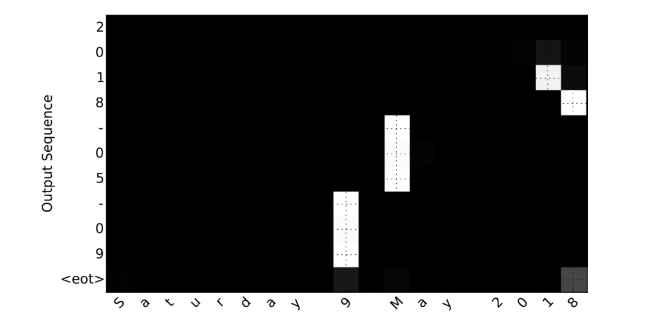

Lưu ý cách đầu ra bỏ qua phần "Thứ Bảy" của đầu vào. Không có bước thời gian đầu ra nào chú ý nhiều đến phần đầu vào đó. Chúng tôi cũng thấy rằng 9 đã được dịch là 09 và May đã được dịch chính xác thành 05, với đầu ra chú ý đến các phần của đầu vào mà nó cần để thực hiện bản dịch. Năm phần lớn yêu cầu nó phải chú ý đến "18" của đầu vào để tạo ra "2018."

<a name='3-1'> </a>
### 3.1 - Thu hút sự chú ý từ mạng

Bây giờ hãy hình dung các giá trị chú ý trong mạng của bạn. Chúng tôi sẽ tuyên truyền một ví dụ thông qua mạng, sau đó trực quan hóa các giá trị của $ \ alpha ^ {\langle t, t '\rangle} $.

Để tìm ra vị trí của các giá trị chú ý, hãy bắt đầu bằng cách in bản tóm tắt của mô hình.

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 30, 37)]     0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 [(None, 64)]         0                                            
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 30, 64)       17920       input_4[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 30, 64)       0           s0[0][0]                         
                                                                 lstm[30][0]                

<Figure size 432x288 with 0 Axes>

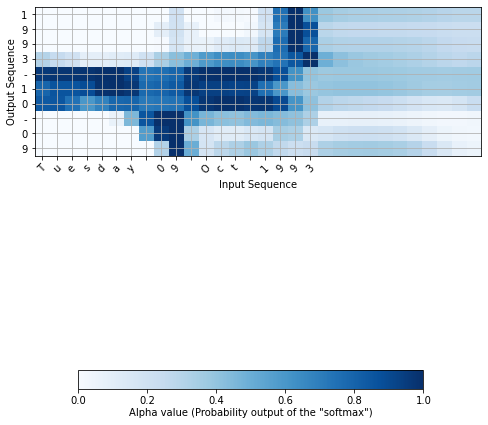

In [ ]:
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, "Tuesday 09 Oct 1993", num = 7, n_s = 64);

### Xin chúc mừng!


Bạn đã hoàn thành nhiệm vụ này

#### Đây là những gì bạn nên nhớ

- Máy dịch mô hình có thể được sử dụng để ánh xạ từ này sang chuỗi khác. Chúng tôi không hữu ích để dịch ngôn ngữ của con người (như tiếng Pháp-> tiếng Anh) mà còn cho các tác vụ như ngày tháng định dạng.
- Chú ý cơ chế cho phép một tập tin mạng vào các phần có đầu liên quan khi sản xuất một phần cụ thể của đầu ra.
- Một mạng sử dụng cơ chế chú thích có thể dịch từ đầu vào có độ dài $ T_x $ sang đầu có độ dài $ T_y $, trong đó $ T_x $ và $ T_y $ có thể khác nhau.
- Bạn có thể định hình các chú thích quan trọng $ \alpha ^ {\langle t, t '\rangle} $ để xem mạng đang chú ý đến điều gì khi tạo ra từng đoạn đầu.